In [98]:
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


import matplotlib.pyplot as plt




import joblib

## Load processed dataset

In [99]:
# Load the dataset
df = pd.read_csv('../data/processed/df_combined_text.csv', index_col=0)
X = df['text'] 
y = df['fraudulent']
df.head()


,fraudulent,text
job_id,,
1,0,customer service cloud video production nz auc...
2,0,commissioning machinery assistant cma u ia wev...
3,0,account executive washington dc u dc washingto...
4,0,bill review manager u fl fort worth spotsource...
5,0,accounting clerk u md job overviewapex environ...


## Spliting the data into training and testing sets

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(13409,)
(13409,)
(4470,)
(4470,)


## Converting text data into TF-IDF features

In [101]:
# TF-IDF transformer is fitted only on the training data

vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1, 2))

# Transform the text data into TF-IDF vectors
vectorizer.fit(X_train)


X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# Save the vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

## Oversampling because the dataset is imbalanced

In [102]:
# Creating an instance of SMOTE
smote = SMOTE()

# Balancing the data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(X_resampled.shape)
print(y_resampled.shape)

(25520, 985983)
(25520,)


## Train the model with GridSearchCV

In [103]:
parameters = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}
model = MultinomialNB()
clf = GridSearchCV(model, parameters,cv=10, n_jobs=-1)
clf.fit(X_resampled, y_resampled)

GridSearchCV(cv=10, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]})

In [104]:
print(clf.best_params_)
print(clf.best_score_)

{'alpha': 0.1}
0.949255485893417


## Test and evaluation

In [105]:
train_accuracy = clf.score(X_resampled, y_resampled)
test_accuracy = clf.score(X_test, y_test)
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.9641065830721003
Test Accuracy: 0.896420581655481


In [106]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

In [107]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)       # Calculate the accuracy
report = classification_report(y_test, y_pred)  # Get the precision, recall, f1-score

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

Accuracy: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      4253
           1       0.21      0.41      0.28       217

    accuracy                           0.90      4470
   macro avg       0.59      0.67      0.61      4470
weighted avg       0.93      0.90      0.91      4470



In [108]:
# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1]) 
print(conf_matrix)

[[3918  335]
 [ 128   89]]


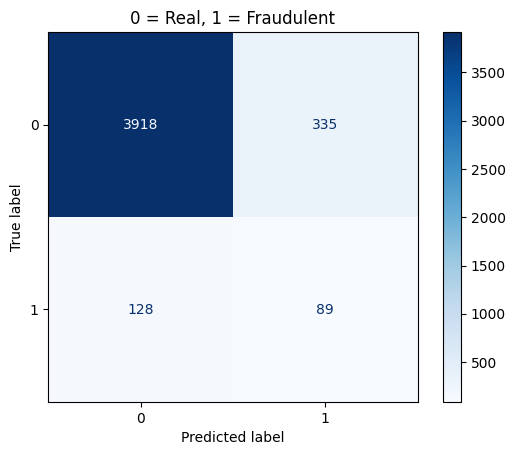

In [109]:
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.title("0 = Real, 1 = Fraudulent")
plt.show()

## Save the model

In [110]:
best_model = clf.best_estimator_
#joblib.dump(best_model, '../models/modelMNB_combined_df.pkl')
